### Required imports

In [1]:
from arch import arch_model
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
from pandas_datareader import DataReader
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
register_matplotlib_converters()
sns.set()


## Volatility Analysis

### 1- Model choice

Stock returns have an asymmetric shock. It is often the case. A piece of “bad news”, or a negative return, such as a drop in the stock price, reduces the value of equity relative to the fixed value of debt of that firm according to Enders (2014). The opposite effect will also be present – an increase in the stock price reduces leverage and risk. It is also often the case, that stocks move more often with the market when the market goes down than when it goes up(Yongmiao Hong et al. , The Review of Financial Studies, 2007). EGARCH model is well suited to model such asymmetric shocks. It adds a conditional component to model the asymmetry in shocks similar to the GJR-GARCH and it doesn't have a non-negative constraint on alpha and beta, making the model faster.

#### Plot of the returns

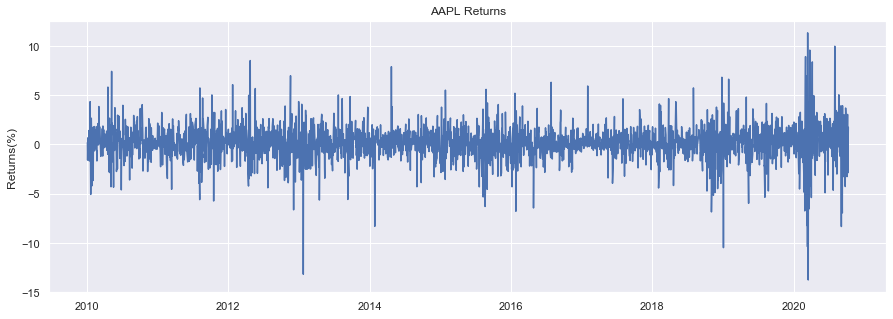

In [2]:
start_date = datetime(2010,1,1)
end_date = datetime(2020,10,9)
aapl = DataReader('AAPL',  'yahoo', start_date, end_date)
returns = pd.DataFrame(np.diff(np.log(aapl['Adj Close'].values)))
returns = 100 * returns
returns.index = aapl.index.values[1:aapl.index.values.shape[0]]
returns.columns = ['AAPL Returns']

plt.figure(figsize=(15,5));
plt.plot(returns.index,returns);
plt.ylabel('Returns(%)');
plt.title('AAPL Returns');

One way to visualize the underlying volatility of the series is to plot the absolute returns ∣y∣:

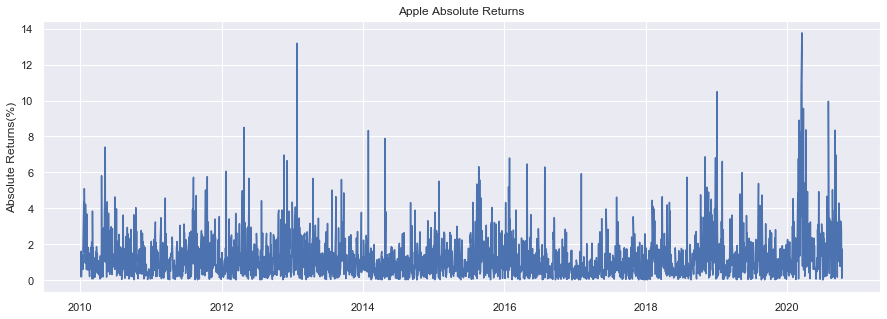

In [3]:
plt.figure(figsize=(15,5))
plt.plot(returns.index, np.abs(returns))
plt.ylabel('Absolute Returns(%)')
plt.title('Apple Absolute Returns');

#### Model specification

Iteration:     10,   Func. Count:     99,   Neg. LLF: 4760.994056625304
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4760.871301667804
            Iterations: 15
            Function evaluations: 140
            Gradient evaluations: 15
                             AR - EGARCH Model Results                              
Dep. Variable:                 AAPL Returns   R-squared:                      -0.000
Mean Model:                              AR   Adj. R-squared:                 -0.000
Vol Model:                           EGARCH   Log-Likelihood:               -4760.87
Distribution:      Standardized Student's t   AIC:                           9533.74
Method:                  Maximum Likelihood   BIC:                           9568.96
                                              No. Observations:                 2618
Date:                      Sat, Oct 10 2020   Df Residuals:                     2612
Time:                              17

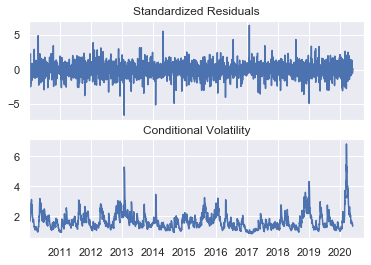

In [4]:
# Specify EGARCH model assumptions
basic_gm = arch_model(returns, p = 1, q = 1, o=1,
                      mean = 'AR', vol = 'EGARCH', dist = 't')
# Fit the model
split_date = datetime(2020,6,1)
gm_result = basic_gm.fit(update_freq = 10, last_obs=split_date)

# Display model fitting summary
print(gm_result.summary())

# Plot fitted results
gm_result.plot();
plt.show();

The coefficients are all significant at the 1% significant level as p-values for all coefficient is less than 1%. The abslolute value of the t-values are all greater than 2 as well. alpha is greater than 0.10 which indicates a spily market as clearly shown on the conditional volatility plot. beta is 0.94 which is in the high end for daily data according to Alexander(2008), meaning that the volatility has high persistency or otherwise stated, past volatility have high impact on current volatility.

#### Analysis of model residuals

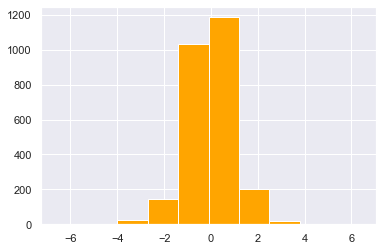

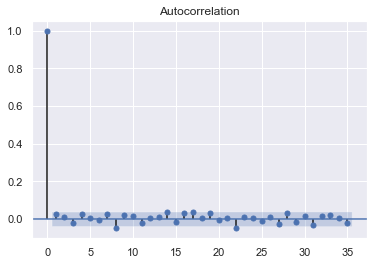

In [7]:
std_resid = gm_result.resid/gm_result.conditional_volatility
std_resid.dropna(inplace=True)
plt.hist(std_resid, facecolor = 'orange',label = 'standardized residuals');
plot_acf(std_resid, alpha=0.05);

In [8]:
# Perform the Ljung-Box test
lb_test = acorr_ljungbox(std_resid , lags = 10, return_df=True)
# Check p-values
lb_test.lb_pvalue

1     0.191196
2     0.377703
3     0.389669
4     0.318130
5     0.447848
6     0.552290
7     0.461829
8     0.093471
9     0.106428
10    0.122627
Name: lb_pvalue, dtype: float64

The pvalue of residuals up to lag 10 is greater than 0.01, so we accept the null hypothesis of residuals that are independently distributed, i.e, there is no autocorrelation in the residuals

The model will be estimated using the first 10 years and 4 months to estimate parameters and then forecasts will be produced for the final period in the sample.

### 2- One step ahead Forecast

In [9]:
# Make 1-period ahead forecast
gm_forecast = gm_result.forecast(method = 'simulation', start=split_date)

# Print the forecast variance
print(gm_forecast.mean[-1:])

                h.1
2020-10-09  0.12645


## Multivariate Analysis
### Equilibrium CAD/USD Exchange Rate

### 1- Describe the economic theories and models used to calculate equilibrium FX

### 2- Indicate macroeconomic variables used to determine the equilibrium FX

### 3- Explain the connection between linear regression and Vector Error Correction (VEC)
Linear regression attempts to model the relationship between two or more variables by fitting a linear equation to observed data. One or more variable are considered to be independent variables, and one variable is considered to be a dependent variable.
The vector auto-regression is a system of regression which contains a set of `m` variables, each of which is expressed as a linear function of `p` lags of itself and of all of the other `m – 1` variables, plus an error term. Both linear regression and VAR use OLS to estimate paramters. When the variables of a VAR are cointegrated, we use a vector error-correction (VEC) which is a special case of VAR.

### 4- Calculate the equilibrium FX using VEC and comment all your results